# Classifying

This notebook tests a number of classification algorithms to determine if it is possible to classify census tracts into their respective clusters (representing gentrification status) using the census' current demographic state.

In [1]:
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import Classifier_helper_functions as helper
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# import the csv that has the clusters assigned to each tract
df = pd.read_csv('CSV_files/clusters.csv')
df.head()

,tractid,cluster,HINC00_PC,MHMVAL00_PC,MRENT00_PC,percent_owneroccupied_00_PC,percent_non-white00_PC,percent_4yrcollege_degree_ormore_PC,cluster_name
0,25025000100,1,-5.209184,56.776227,50.111359,-12.523463,27.326426,-24.905530,Low Income
1,25025000201,1,-16.972574,100.301205,41.775984,-6.081155,22.631076,12.614115,Low Income
2,25025000202,1,-24.082755,56.414890,58.414634,-7.606378,2.145146,11.102718,Low Income
3,25025000301,2,25.755612,91.091418,51.287333,4.772562,45.576692,37.542492,Stable
4,25025000302,1,-15.312205,24.161852,15.713135,-3.596587,32.146323,-1.157077,Low Income


In [3]:
# subset tracts and clusters
df1=df.iloc[:,0:2]

In [4]:
# import the data from the 2000 census 
df2 = pd.read_csv('CSV_files/Final_2000_data.csv',index_col=0)
df3 = pd.read_csv('CSV_files/Final_2000_data_sample.csv',index_col=0)

In [5]:
# join the dataframes
df = df1.merge(df2,how='inner',on='tractid')

df_final = df.merge(df3,how='inner',on='tractid')
df_final.set_index('tractid',inplace=True)

In [6]:
df_final['cluster'].value_counts()

2    82
1    77
0    31
3     1
Name: cluster, dtype: int64

In [7]:
# lets drop classes 3 since it only has 1 tract
df_final = df_final[df_final['cluster']!=3]

In [8]:
df_final.columns

Index(['cluster', 'state', 'county', 'tract', 'POP00', 'NHWHT00', 'NHBLK00',
       'NTV00', 'ASIAN00', 'HISP00', 'HAW00', 'INDIA00', 'CHINA00', 'FILIP00',
       'JAPAN00', 'KOREA00', 'VIET00', 'MEX00', 'PR00', 'CUBAN00', 'HU00',
       'VAC00', 'OHU00', 'A18UND00', 'A60UP00', 'A75UP00', 'AGEWHT00',
       'A15WHT00', 'A60WHT00', 'AGEBLK00', 'A15BLK00', 'A60BLK00', 'AGEHSP00',
       'A15HSP00', 'A60HSP00', 'AGENTV00', 'A15NTV00', 'A60NTV00', 'AGEASN00',
       'A15ASN00', 'A60ASN00', 'FAMILY00', 'FHH00', 'OWN00', 'RENT00',
       'GlobD00', 'GlobG00', 'percent_white00', 'percent_black00',
       'percent_asian00', 'percent_hispanic00', 'percent_indian00',
       'percent_chinese00', 'percent_filip00', 'percent_japan00',
       'percent_korean00', 'percent_viet00', 'percent_mex00', 'percent_pr00',
       'percent_cuban00', 'percent_vacant_housing00',
       'percent_occupied_housing00', 'percent_under18_00',
       'percent_60andup_00', 'percent_75andup_00', 'percent_owneroccupied_00'

In [9]:
df_final['cluster'].value_counts()

2    82
1    77
0    31
Name: cluster, dtype: int64

In [10]:
# split into X and Y
X = df_final[['percent_white00', 'percent_black00',
       'percent_asian00', 'percent_hispanic00', 'percent_indian00',
       'percent_chinese00', 'percent_filip00', 'percent_japan00',
       'percent_korean00', 'percent_viet00', 'percent_mex00', 'percent_pr00',
       'percent_cuban00', 'percent_vacant_housing00',
       'percent_occupied_housing00', 'percent_under18_00',
       'percent_60andup_00', 'percent_75andup_00', 'percent_owneroccupied_00',
       'percent_renteroccupied_00', 'percent_non-white00', 'INCPC00', 'HINC00',
       'MHMVAL00', 'MRENT00', 'percent_foreign_born', 'percent_naturalized',
       'percent_recent_immigrants(10)', 'percent_other_languages',
       'percent_hs_degree_orless', 'percent_4yrcollege_degree_ormore',
       'percent_married', 'percent_unemployed', 'percent_employed',
       'percent_professional', 'percent_manufacturing',
       'percent_self_employed', 'percent_poverty', 'percent_houses_30yrsago',
       'percent_multiunit_houses']]
Y = df_final['cluster']
Y=Y.astype('str')

# Dummy Classifier

In [11]:
# train test split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=.2)

In [12]:
# create instance of the class
dummy_clf = DummyClassifier('most_frequent')
dummy_clf.fit(X_train,y_train)
y_hat_train = dummy_clf.predict(X_train)
y_hat_test = dummy_clf.predict(X_test)

In [13]:
print(accuracy_score(y_hat_train,y_train))
print(accuracy_score(y_hat_test,y_test))

0.4473684210526316
0.3684210526315789


Confusion matrix, without normalization
[[ 0  0  3]
 [ 0  0 21]
 [ 0  0 14]]


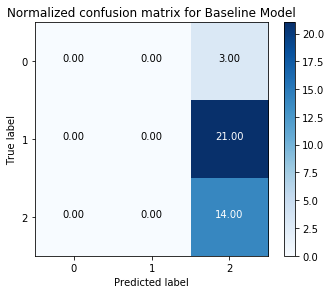

In [14]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
plt.figure(figsize=(5,4))

helper.plot_confusion_matrix(cnf_matrix, normalize=False,classes=[0,1,2],
                      title='Normalized confusion matrix for Baseline Model')

plt.savefig('Dummy_Confusion')
plt.show()

## KNN

In [21]:
knn = KNeighborsClassifier()
parameters={'n_neighbors':[10,12,13,14,15,16,17,18,19,20]}
clf = GridSearchCV(knn,parameters,cv=5)
clf.fit(X,Y)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [10, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
clf.best_params_

{'n_neighbors': 14}

In [23]:
knn = KNeighborsClassifier(n_neighbors=14)
helper.stratified_k_fold(knn,3,X,Y)

('Train scores from each iteration:[0.544, 0.592, 0.592]',
 'Average K-Fold train score: 0.5760000000000001',
 'Test scores from each iteration:[0.49230769230769234, 0.4461538461538462, 0.4307692307692308]',
 'Average K-Fold test score: 0.4564102564102564')

## Decision Tree

In [18]:
dt = DecisionTreeClassifier()
parameters={'criterion':['gini','entropy'],
            'max_depth':[5,10,15],
            'min_samples_split':[2,3,4,5,6,7],
            'min_samples_leaf':[1,2,3,4,5,6,7],
            'max_features':[1,2,3,4,5,6,7]   
}
clf_2 = GridSearchCV(dt,parameters,cv=5)
clf_2.fit(X,Y)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'max_features': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
clf_2.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 6}

In [25]:
dt= DecisionTreeClassifier(criterion='entropy',max_depth=5,max_features=4,min_samples_leaf=5,min_samples_split=6)

helper.stratified_k_fold(dt,5,X,Y)

('Train scores from each iteration:[0.74, 0.7466666666666667, 0.6666666666666666, 0.7, 0.74]',
 'Average K-Fold train score: 0.7186666666666668',
 'Test scores from each iteration:[0.425, 0.35, 0.45, 0.55, 0.6]',
 'Average K-Fold test score: 0.475')

## Random Forest

In [26]:
rf = RandomForestClassifier()
parameters={'criterion':['gini','entropy'],
            'max_depth':[10,15,20],
            'min_samples_split':[2,3,4,5,6,7],
            'min_samples_leaf':[1,2,3,4,5,6,7],
            'max_features':[1,2,3,4,5,6,7]
    }
clf_3 = GridSearchCV(dt,parameters,cv=5,n_jobs=-1)
clf_3.fit(X,Y)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'max_features': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
clf_3.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 6,
 'min_samples_split': 7}

In [32]:
rt = RandomForestClassifier(criterion='gini',max_depth=10,max_features=2,min_samples_leaf=6,min_samples_split=7)
helper.stratified_k_fold(rt,5,X,Y)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


('Train scores from each iteration:[0.74, 0.7733333333333333, 0.74, 0.7733333333333333, 0.74]',
 'Average K-Fold train score: 0.7533333333333333',
 'Test scores from each iteration:[0.55, 0.7, 0.475, 0.6, 0.625]',
 'Average K-Fold test score: 0.5900000000000001')

## XGBoost

In [33]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))


Training Accuracy: 100.0%
Validation accuracy: 55.26%


In [34]:
param_grid = {
    "learning_rate": [0.1,0.2,0.3,0.4],
    'max_depth': [2,3,4,5,6],
    'min_child_weight': [10,12,13,14,15],
    'subsample': [0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [60]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5, n_jobs=1)
grid_clf.fit(X, Y)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.3
max_depth: 2
min_child_weight: 12
n_estimators: 5
subsample: 0.7

Training Accuracy: 71.71%
Validation accuracy: 71.05%


/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [59]:
xgb = XGBClassifier(learning_rate=0.3,max_depth=2,min_child_weight=12,n_estimators=5,subsample=0.7)
helper.stratified_k_fold(xgb,7,X,Y)

('Train scores from each iteration:[0.6666666666666666, 0.6666666666666666, 0.6790123456790124, 0.6666666666666666, 0.7037037037037037, 0.7345679012345679, 0.6851851851851852]',
 'Average K-Fold train score: 0.6860670194003528',
 'Test scores from each iteration:[0.5714285714285714, 0.4642857142857143, 0.5714285714285714, 0.6071428571428571, 0.6428571428571429, 0.42857142857142855, 0.5357142857142857]',
 'Average K-Fold test score: 0.5459183673469387')

## Predict using 2010 data!!!!!!

In [ ]:
# import the data from the 2000 census 
df2 = pd.read_csv('CSV_files/Final_2010_data.csv',index_col=0)
df3 = pd.read_csv('CSV_files/Final_2010_data_sample.csv',index_col=0)

In [ ]:
# join the dataframes
df = df3.merge(df2,how='inner',on='tractid')